In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from __future__ import annotations
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import IPython.display
from typing import List, Tuple, Union

import candle
import candle.functions as F
from candle import Tensor, Parameter, Module, randn

## (1) Investigate the "step function"-looking loss functions

Phenomenon: training loss looks like a step function between epoch boundaries.

Explanation: overfitting / gradient noise
* Within epoch, example X doesn't help with example Y for any different (X, Y), and so fitting on X increases loss on other examples Y
* Between epoch boundaries (say from epoch 3 to epoch 4), we see and fit on example X one more time, leading to lower loss in a stepwise fashion

In [3]:
class Config:
    # Optimization configs
    
    ITERATIONS = 2000
    BATCH_SIZE = 1000
    LEARNING_RATE = 3e-3
    WEIGHT_DECAY = 0.0
    
    DASHBOARD_REFRESH_ITERS = 100
    
    # Model architecture configs

    HIDDEN_DIM = 128
    LAYERS = 2

    # Synthetic data config

    DATASET_SIZE = 100_000
    DATASET_DIM = 100

    
config = Config()

In [4]:
class MLP(Module):

    def __init__(self,
                 width: int,
                 layers: int):
        super().__init__()

        self.input_layer = candle.Linear(config.DATASET_DIM, width)
        self.layers = candle.ParameterList([candle.Linear(width, width) for _ in range(layers - 1)])
        self.output_layer = candle.Linear(width, 1)
        

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        
        for layer in self.layers:
            x = layer(x)
            x = F.relu(x)
            
        x = self.output_layer(x).flatten()

        return x

In [5]:
X_train = candle.randn(config.DATASET_SIZE, config.DATASET_DIM)
y_train = candle.randn(config.DATASET_SIZE)


def loss_fn(output, y_batch):
    assert output.shape == y_batch.shape
    return ((output - y_batch) ** 2).mean()

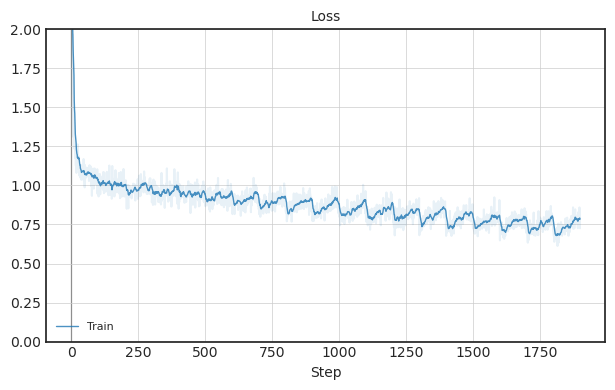

In [6]:
model = MLP(width=config.HIDDEN_DIM,
            layers=config.LAYERS)

optimizer = candle.optimizer.AdamW(model.parameters(),
                                   learning_rate=config.LEARNING_RATE,
                                   weight_decay=config.WEIGHT_DECAY)


writer = candle.Dashboard()
writer.change_settings('smoothness', 10)
writer.change_settings('ylim', (0, 2), 'Loss')

data_loader = candle.DataLoader(X_train, y_train, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)
data_iterator = iter(data_loader)

for iteration in range(config.ITERATIONS):
    
    model.train()

    try:
        (X_batch, y_batch) = next(data_iterator)
    except StopIteration:
        data_iterator = iter(data_loader)
        (X_batch, y_batch) = next(data_iterator)

    optimizer.zero_grad()
    output = model(X_batch)
    loss = loss_fn(output, y_batch)
    loss.backward()
    
    optimizer.step()

    # ----------------
    # Update dashboard
    # ----------------

    model.eval()
    writer.add_scalars('Loss', {'Train': float(loss.data)})

    if iteration % config.DASHBOARD_REFRESH_ITERS == 0:
        writer.plot(clear_output=True)

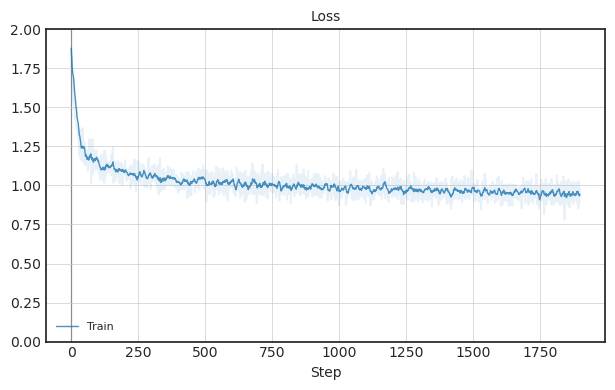

In [7]:
# 4x learning rate

LR_SCALE = 10

model = MLP(width=config.HIDDEN_DIM,
            layers=config.LAYERS)

optimizer = candle.optimizer.AdamW(model.parameters(),
                                   # learning_rate=config.LEARNING_RATE,
                                   learning_rate=config.LEARNING_RATE / LR_SCALE,
                                   weight_decay=config.WEIGHT_DECAY)


writer = candle.Dashboard()
writer.change_settings('smoothness', 10)
writer.change_settings('ylim', (0, 2), 'Loss')

data_loader = candle.DataLoader(X_train, y_train, batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)
data_iterator = iter(data_loader)

for iteration in range(config.ITERATIONS):
# for iteration in range(config.ITERATIONS * LR_SCALE):
    
    model.train()

    try:
        (X_batch, y_batch) = next(data_iterator)
    except StopIteration:
        data_iterator = iter(data_loader)
        (X_batch, y_batch) = next(data_iterator)

    optimizer.zero_grad()
    output = model(X_batch)
    loss = loss_fn(output, y_batch)
    loss.backward()
    
    optimizer.step()

    # ----------------
    # Update dashboard
    # ----------------

    model.eval()
    writer.add_scalars('Loss', {'Train': float(loss.data)})

    if iteration % config.DASHBOARD_REFRESH_ITERS == 0:
        writer.plot(clear_output=True)

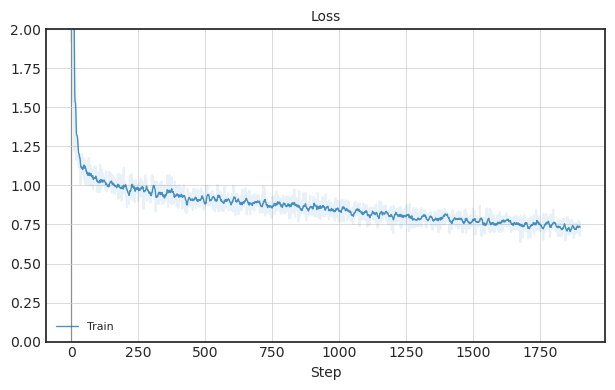

In [8]:
# Sample with replacement

model = MLP(width=config.HIDDEN_DIM,
            layers=config.LAYERS)

optimizer = candle.optimizer.AdamW(model.parameters(),
                                   learning_rate=config.LEARNING_RATE,
                                   weight_decay=config.WEIGHT_DECAY)


writer = candle.Dashboard()
writer.change_settings('smoothness', 10)
writer.change_settings('ylim', (0, 2), 'Loss')

for iteration in range(config.ITERATIONS):
    
    model.train()

    indices = np.random.choice(range(config.DATASET_SIZE), config.BATCH_SIZE)
    (X_batch, y_batch) = (X_train[indices], y_train[indices])

    optimizer.zero_grad()
    output = model(X_batch)
    loss = loss_fn(output, y_batch)
    loss.backward()
    
    optimizer.step()

    # ----------------
    # Update dashboard
    # ----------------

    model.eval()
    writer.add_scalars('Loss', {'Train': float(loss.data)})

    if iteration % config.DASHBOARD_REFRESH_ITERS == 0:
        writer.plot(clear_output=True)